In [68]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [69]:
from PIL import Image

display(Image.fromarray(train_images[5], 'L'))
train_images[5]/255

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [70]:
from math import exp
import numpy as np
def sigmoid(x: float | np.floating) -> float:
    return 1 / (1 + exp(-x))

def sigmoid_derivative(x: float | np.floating) -> float:
    return sigmoid(x) * (1 - sigmoid(x))

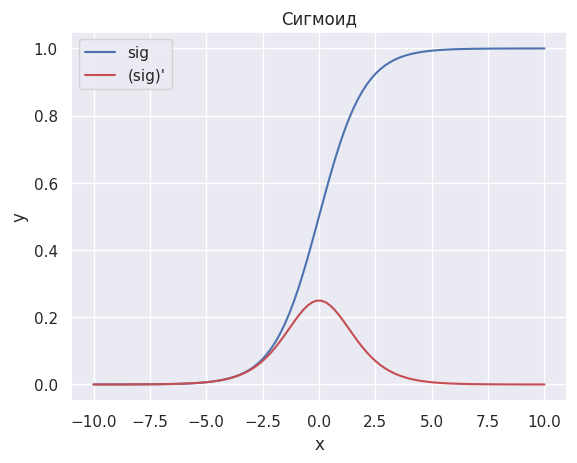

In [71]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

x = np.linspace(-10, 10, 100)
y = [sigmoid(x) for x in x]
dy = [sigmoid_derivative(x) for x in x]

fig, ax = plt.subplots()

ax.set_title('Сигмоид')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(x, y, color = 'b', label = 'sig');
ax.plot(x, dy, color = 'r', label = '(sig)\'');
ax.legend()


In [72]:
train_labels.shape[0]


60000

In [73]:
import random
import numpy as np  

class Neuron:

    def __init__(self, size: tuple[int, int]):
        self.init_weights(size)

    def init_weights(self, size: tuple[int, int], min: float = -0.03, max: float = 0.03):
        self._weights = np.random.uniform(min, max, size)
        self._bias = np.random.uniform(min, max)

    def correct_weights(self, inputs: np.ndarray, correction: float): 
        self._weights += (inputs * correction)
        self._bias += correction

    def get_weights(self):
        return self._weights

    def compute(self, inputs: np.ndarray) -> tuple[float | np.floating, float]:
        weighted_sum = self._weighted_sum(inputs)
        output = self._activation(weighted_sum)

        return weighted_sum, output

    def _activation(self, w_sum: np.floating) -> float:
        return sigmoid(w_sum)

    def _weighted_sum(self, inputs: np.ndarray) -> np.floating:
        return (np.sum(inputs * self._weights) + self._bias)


In [74]:
class PlotData:
    def __init__(self, data: list, title: str, scalex: str = 'linear', scaley: str = 'linear', style: str = '-'):
        self.data = data
        self.title = title
        self.scalex = scalex
        self.scaley = scaley
        self.style = style

def plot_weights_and_success(
        final_weights: dict[int, np.ndarray],
        graphs_and_titles: list[PlotData]
        ):
    
    import matplotlib.pyplot as plt
    colormap = 'coolwarm'

    fig, hmaps = plt.subplots(1, len(final_weights))
    # fig.set_size_inches(3, 1)

    import matplotlib.colors

    print('Тепловая карта весов: ')
    for (label, weights), axis in zip(final_weights.items(), hmaps):
        colnorm = matplotlib.colors.CenteredNorm(vcenter=0)
        axis.imshow(weights, cmap=colormap, norm=colnorm)
        
        axis.tick_params(
            axis='both',
            labelbottom = False,
            labelleft = False
        )
        axis.set_title(str(label))
        axis.grid(False)
    
    fig.tight_layout()


    fig, graphs = plt.subplots(len(graphs_and_titles), 1)
    for axis, pdata in zip(graphs, graphs_and_titles):
        axis.tick_params(axis='y', which='minor')
        from matplotlib.ticker import FormatStrFormatter
        axis.yaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
        axis.plot(pdata.data, pdata.style)
        axis.set_xscale(pdata.scalex) # type: ignore
        axis.set_yscale(pdata.scaley) # type: ignore
        axis.set_title(pdata.title)
    fig.tight_layout()
    fig.set_dpi(72)

    plt.show()

In [75]:
class PerceptronGradDescent:
    def __init__(self, size: tuple[int, int] = (28, 28)) -> None:
        self._neurons = {label: Neuron(size=size) for label in range(10)}
        self.THRESHOLD = 0.5
        self._error_threshold = 0.01

    def process_neurons(self, inputs: np.ndarray) -> tuple[dict[int, float], dict[int, float]]:
        w_sums =  {label: neuron._weighted_sum(inputs) for label, neuron in self._neurons.items()}
        outputs = {label: self._neurons[label]._activation(w_sum) for label, w_sum in w_sums.items()}
        return w_sums, outputs
    
    def calculate_errors(self, outputs: dict[int, float], true_label: int) -> tuple[dict[int, float], int, int]:
        errors = {}

        total = 0
        success = 0
        for label, value in outputs.items():
            total += 1
            if label == true_label:
                if value > self.THRESHOLD:
                    success += 1
                errors[label] = 1 - value

            if label != true_label:
                if value <= self.THRESHOLD:
                    success += 1
                errors[label] = 0 - value

        return errors, success, total
        pass

    def calculate_mse(self, errors: dict[int, float]) -> float:
        return 0.5 * sum(errors.values())

    def calculate_deltas(
            self,
            w_sums: dict[int, float],
            errors: dict[int, float]
    ) -> dict[int, float]:
        deltas = {}

        for label, error in errors.items():
            deltas[label] = -error * sigmoid_derivative(w_sums[label]) 

        return deltas

    def calculate_weights_corrections(
            self,
            prev_corrections: dict[int, float],
            learning_rate: float,
            deltas:  dict[int, float],
            inputs: np.ndarray
    ) -> dict[int, float]:
        return {label:-learning_rate * delta for label, delta in deltas.items()}
        pass

    def correct_weights(self, corrections: dict[int, float], inputs: np.ndarray):
        for label, correction in corrections.items():
            self._neurons[label].correct_weights(inputs, correction)
        pass

    def train_epochs(self, learning_rate: float, epochs: int, images: np.ndarray, labels: np.ndarray):
        loss_total = 0
        loss = []
        epoch_train_count_total = 0
        epoch_train_count_success = 0
        successes_epochs = []
        success_iterations = []

        weight_correction = {label: 0.0 for label in range(10)}

        for _ in range(epochs):
            for image, label in zip(images, labels):
                w_sums, outputs = self.process_neurons(image)
                errors, success, total = self.calculate_errors(outputs, true_label=label)
                loss_current = self.calculate_mse(outputs)
                deltas = self.calculate_deltas(w_sums, errors)
                weights_corrections = self.calculate_weights_corrections(
                    weight_correction,
                    learning_rate,
                    deltas,
                    inputs=image
                )
                self.correct_weights(weights_corrections, inputs=image)
                
                loss_total += loss_current / labels.shape[0]
                epoch_train_count_success += success
                epoch_train_count_total += total
                loss.append(loss_total)
                success_iterations.append(epoch_train_count_success/epoch_train_count_total)

            successes_epochs.append(epoch_train_count_success/epoch_train_count_total)

        final_weights = {label:neuron.get_weights() for label, neuron in self._neurons.items()}

        plot_weights_and_success(
            final_weights = final_weights,
            graphs_and_titles=[
                PlotData(loss, 'Ошибки с каждой итерацией', scalex='log'),
                PlotData(success_iterations, 'Успех с каждой итерацией', scalex='log'),
                PlotData(successes_epochs, 'Успех с каждой эпохой')
            ]
        )


In [76]:
epochs = PerceptronGradDescent()



Тепловая карта весов: 


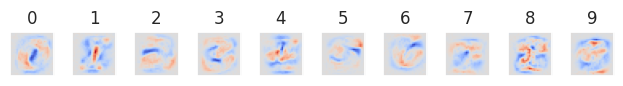

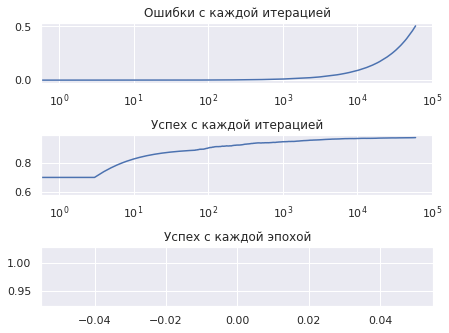

         18323874 function calls (18100175 primitive calls) in 47.212 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   600000    4.355    0.000    4.355    0.000 1232921279.py:13(correct_weights)
       10    0.000    0.000    0.000    0.000 1232921279.py:17(get_weights)
   600000    0.460    0.000    1.220    0.000 1232921279.py:26(_activation)
   600000    3.098    0.000   13.922    0.000 1232921279.py:29(_weighted_sum)
    60000    5.214    0.000    5.231    0.000 3398920437.py:12(calculate_errors)
    60000    0.133    0.000    0.232    0.000 3398920437.py:32(calculate_mse)
    60000    0.807    0.000    2.943    0.000 3398920437.py:35(calculate_deltas)
    60000    0.159    0.000    0.450    0.000 3398920437.py:47(calculate_weights_corrections)
    60000    0.274    0.000    0.274    0.000 3398920437.py:54(<dictcomp>)
    60000    0.816    0.000    5.186    0.000 3398920437.py:57(correct_weights)
        1    1.066  

In [77]:
import cProfile

cProfile.run('epochs.train_epochs(learning_rate=0.1, epochs=1, images=train_images/255, labels=train_labels)')

In [86]:
inputs = np.random.uniform(0, 1, (28, 28))
weights = np.random.uniform(-0.03, 0.03, (28,28))
bias = np.random.uniform(-0.003, 0.003)

f_inputs = inputs.flatten()
f_weights = weights.flatten()

def w_sum():
    return np.sum(weights * inputs) + bias

def f_w_sum():
    return np.dot(weights, inputs) + bias

def test():
    for _ in range(120_000):
        w_sum()
        f_w_sum()

cProfile.run('test()')

         1680004 function calls in 4.597 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   120000    0.734    0.000    1.687    0.000 660436018.py:11(f_w_sum)
        1    0.213    0.213    4.597    4.597 660436018.py:14(test)
   120000    0.528    0.000    2.697    0.000 660436018.py:8(w_sum)
   120000    0.186    0.000    0.953    0.000 <__array_function__ internals>:177(dot)
   120000    0.202    0.000    2.169    0.000 <__array_function__ internals>:177(sum)
        1    0.000    0.000    4.597    4.597 <string>:1(<module>)
   120000    0.040    0.000    0.040    0.000 fromnumeric.py:2157(_sum_dispatcher)
   120000    0.340    0.000    1.776    0.000 fromnumeric.py:2162(sum)
   120000    0.405    0.000    1.385    0.000 fromnumeric.py:69(_wrapreduction)
   120000    0.183    0.000    0.183    0.000 fromnumeric.py:70(<dictcomp>)
   120000    0.039    0.000    0.039    0.000 multiarray.py:736(dot)
        1    0.000    0

In [93]:
a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])
a.flatten().reshape(3, -1)

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])